In [30]:
import json
import tensorflow as tf

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Hyperparameters

We placed the hyperparameters in the cell below so you can easily tweak it later:

In [32]:
datastore=[]

with open("sarcasm.json", 'r') as f:
    for line in f:
        datastore.append(json.loads(line))

In [33]:
sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

## 

This is an extension of the week2 lab from the Coursera Course Natural Language Processing in Tensorflow. There was a section in the week's tutorials which demonstrated how model loss changed as you varied the embedding_layers, vocab_size etc. which was used for tokenization and model generation. I decided to split out the separate sections related to creating the model into methods so that I could try this.

## Hyperparameters

In [34]:
class HyperParam:

    def __init__(self, name:str, vocab_size:int, embedding_dim:int, max_length:int, training_size:int):
        self._name=name
        self._vocab_size=vocab_size
        self._embedding_dim=embedding_dim
        self._max_length=max_length
        self._training_size=training_size
        self._trunc_type='post'
        self._padding_type='post'
        self._oov_tok="<OOV>"
    

    def __str__(self):
        return f"name: {self._name}, vocab_size: {self._vocab_size}, embedding_dim: {self._embedding_dim}, max_length{self._max_length}"

## Data Splitting / Model Definition Methods

In [35]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def get_testing_and_training_sequences(tokens : list[str], labels : list[int], hyper_param : HyperParam):

    training_sentences = tokens[0:hyper_param._training_size]
    testing_sentences = tokens[hyper_param._training_size:]

    training_labels = labels[0:hyper_param._training_size]
    testing_labels = labels[hyper_param._training_size:]

    training_tokenizer = Tokenizer(num_words=hyper_param._vocab_size, oov_token=hyper_param._oov_tok)
    training_tokenizer.fit_on_texts(training_sentences)
    word_index = training_tokenizer.word_index
    
    training_sequences = training_tokenizer.texts_to_sequences(training_sentences)
    padded_training_sequences = pad_sequences(training_sequences, maxlen=hyper_param._max_length, 
        padding=hyper_param._padding_type, truncating=hyper_param._trunc_type)

    testing_sequences = training_tokenizer.texts_to_sequences(testing_sentences)
    padded_testing_sequences = pad_sequences(testing_sequences, maxlen=hyper_param._max_length, 
        padding=hyper_param._padding_type, truncating=hyper_param._trunc_type)

    return padded_training_sequences, training_labels, padded_testing_sequences, testing_labels

In [36]:
def get_model(vocab_size : int, embedding_dim : int, input_length : int):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=input_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [37]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, name : str, loss_type : str):
  plt.plot(history.history[loss_type])
  plt.plot(history.history['val_'+loss_type])
  plt.xlabel("Epochs")
  plt.title(name)
  plt.legend([loss_type, 'val_'+loss_type])
  plt.show()

## Generate Model History

In [38]:
hyper_params=[]

In [55]:
actual_max_len = max(len(s) for s in sentences for w in s.split(' '))
actual_vocab_size = len(set([s for s in sentences for w in s.split(' ')]))
actual_embedding_dim = int(actual_max_len * 0.8)

In [56]:
print(f"actual_max_len {actual_max_len}, actual_vocab_size {actual_vocab_size}, actual_embedding_dim {actual_embedding_dim}")

actual_max_len 254, actual_vocab_size 26602, actual_embedding_dim 203


In [50]:
hyper_params.append(HyperParam(name="model 1", vocab_size=1000, embedding_dim=16, max_length=32, training_size=20000))
hyper_params.append(HyperParam(name="model 2", vocab_size=10000, embedding_dim=32, max_length=16, training_size=20000))
hyper_params.append(HyperParam(name="model 3", vocab_size=1000, embedding_dim=16, max_length=16, training_size=20000))
hyper_params.append(HyperParam(name="model 4", vocab_size=actual_vocab_size, embedding_dim=actual_embedding_dim, max_length=actual_max_len, training_size=20000))

In [51]:
print(hyper_params[0])

name: model 1, vocab_size: 1000, embedding_dim: 16, max_length32


In [52]:
history=[]

In [53]:
def compile_and_train_model(hyper_param : HyperParam, num_epochs : int):
    padded_training_sequences, training_labels, padded_testing_sequences, testing_labels = get_testing_and_training_sequences(tokens=sentences, labels=labels, hyper_param=hyper_param)
    training_labels = np.array(training_labels)
    testing_labels = np.array(testing_labels)
    model = get_model(vocab_size=hyper_param._vocab_size, embedding_dim=hyper_param._embedding_dim, input_length=hyper_param._max_length)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    # Train the model
    return model.fit(padded_training_sequences, training_labels, epochs=num_epochs, validation_data=(padded_testing_sequences, testing_labels), verbose=2)

Running all of the models and storing history.

In [54]:
num_epochs = 30

for param in hyper_params:
    h = compile_and_train_model(hyper_param=param, num_epochs=num_epochs)
    history.append(h)

Epoch 1/30
625/625 - 2s - loss: 0.5873 - accuracy: 0.6827 - val_loss: 0.4394 - val_accuracy: 0.7973 - 2s/epoch - 3ms/step
Epoch 2/30
625/625 - 1s - loss: 0.3971 - accuracy: 0.8193 - val_loss: 0.4021 - val_accuracy: 0.8159 - 1s/epoch - 2ms/step
Epoch 3/30
625/625 - 1s - loss: 0.3703 - accuracy: 0.8300 - val_loss: 0.3981 - val_accuracy: 0.8150 - 1s/epoch - 2ms/step
Epoch 4/30
625/625 - 1s - loss: 0.3588 - accuracy: 0.8383 - val_loss: 0.3994 - val_accuracy: 0.8128 - 1s/epoch - 2ms/step
Epoch 5/30
625/625 - 1s - loss: 0.3549 - accuracy: 0.8406 - val_loss: 0.4019 - val_accuracy: 0.8153 - 1s/epoch - 2ms/step
Epoch 6/30
625/625 - 1s - loss: 0.3530 - accuracy: 0.8386 - val_loss: 0.4018 - val_accuracy: 0.8146 - 1s/epoch - 2ms/step
Epoch 7/30
625/625 - 1s - loss: 0.3510 - accuracy: 0.8413 - val_loss: 0.4030 - val_accuracy: 0.8137 - 1s/epoch - 2ms/step
Epoch 8/30
625/625 - 1s - loss: 0.3482 - accuracy: 0.8415 - val_loss: 0.4042 - val_accuracy: 0.8125 - 1s/epoch - 2ms/step
Epoch 9/30
625/625 - 1s 

TypeError: Dimension value must be integer or None or have an __index__ method, got value '203.20000000000002' with type '<class 'float'>'

name: model 1, vocab_size: 1000, embedding_dim: 16, max_length32


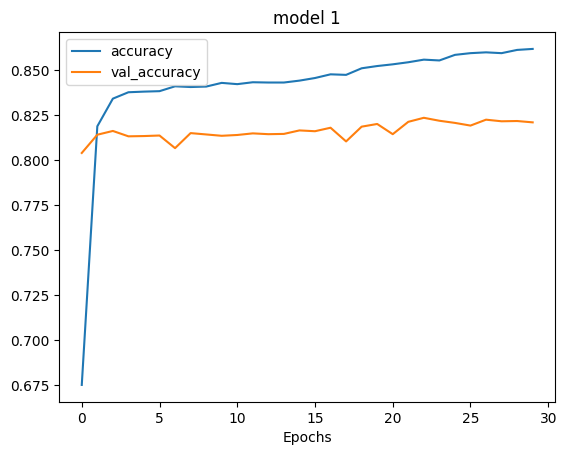

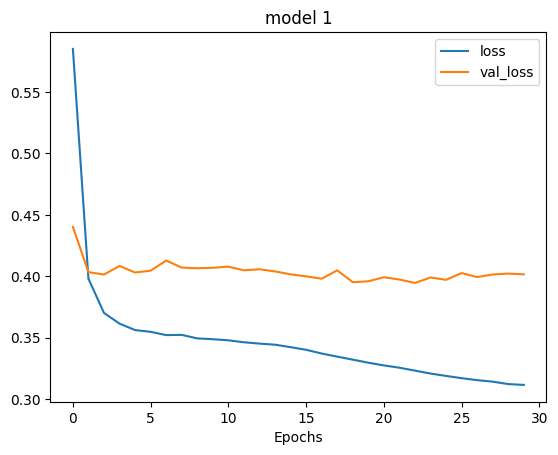

name: model 2, vocab_size: 10000, embedding_dim: 32, max_length16


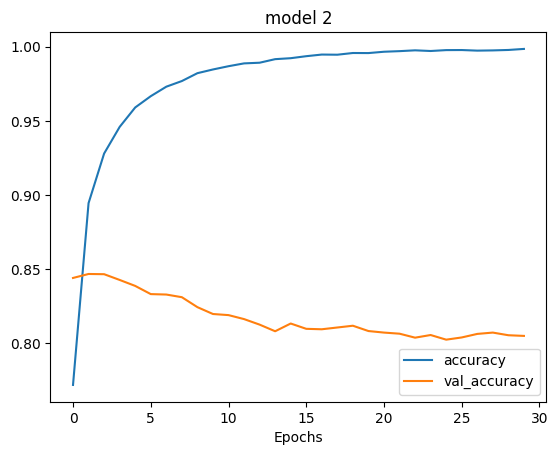

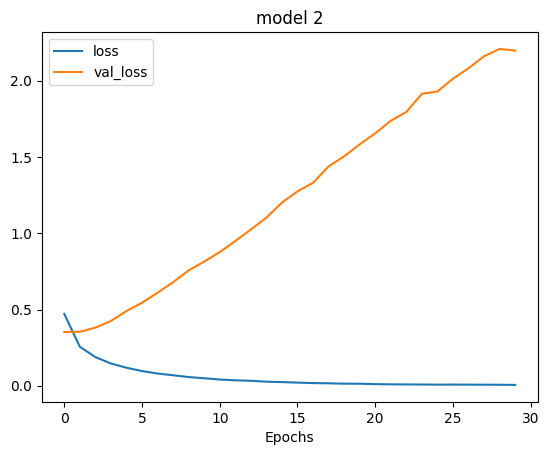

name: model 3, vocab_size: 1000, embedding_dim: 16, max_length16


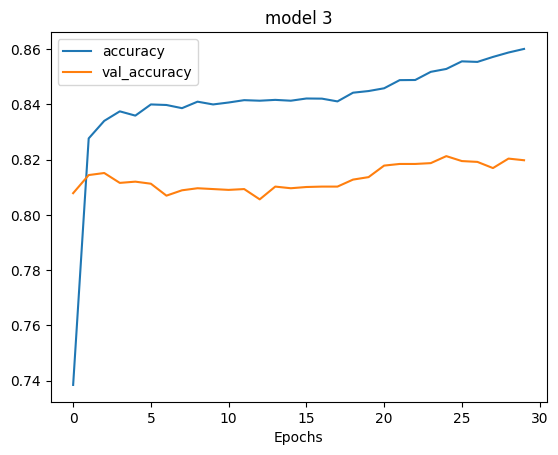

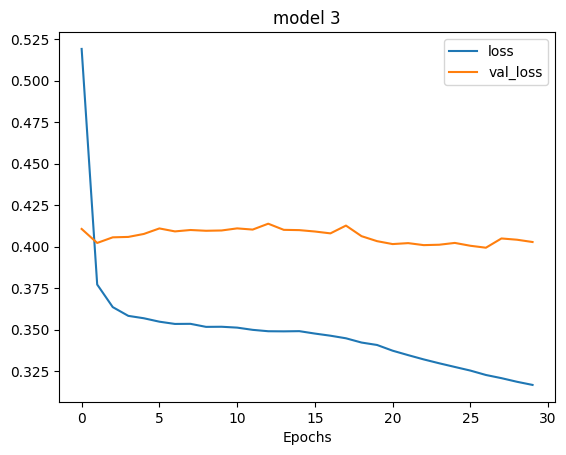

name: model 4, vocab_size: 26602, embedding_dim: 16, max_length254


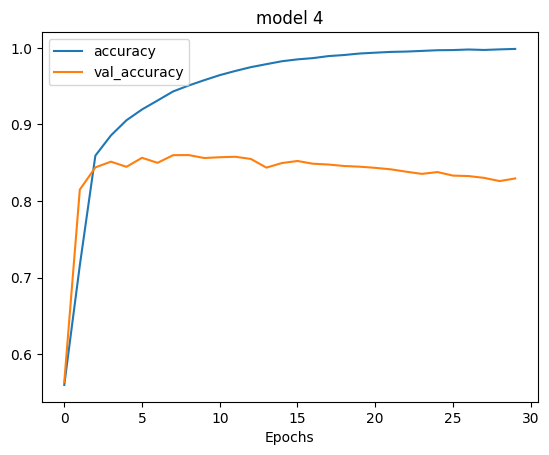

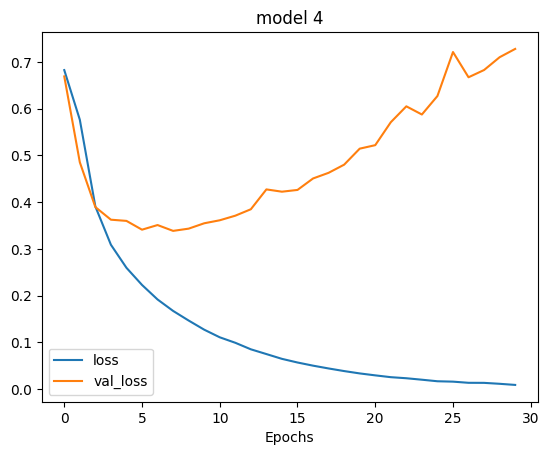

In [ ]:
for i, param in enumerate(hyper_params):
    print(param)
    h = history[i]
    plot_graphs(h, param._name, "accuracy")
    plot_graphs(h, param._name, "loss")